In [ ]:
!pip install plotly

In [33]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o65.sessionState

## Re-read from save

In [5]:
read_bucket = "gs://msca-bdp-students-bucket/shared_data/xiuan/commits_sampled.parquet"
result = spark.read.parquet(read_bucket)

# Filter out rows where "message" or "subject" is an empty string
sampling_result = result.filter(
    (F.col("message") != "") & (F.col("subject") != "")
)

# Verify the results
sampling_result.show(5, truncate=False)

+------------------------------+---------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
rows = sampling_result.count()
print(f"Sampled table contains {rows} rows")
sampling_result.limit(5)

Sampled table contains 37402 rows


repo_name_exploded,subject,message
Alucard24/Alucard...,pwc: Add support ...,pwc: Add support ...
davem330/net-next,V4L/DVB (11981): ...,V4L/DVB (11981): ...
BoyGau/linux,perf session: Add...,perf session: Add...
mercadolibre/chico,Documentation Update,Documentation Upd...
JiangtianLi/kuber...,Merge pull reques...,Merge pull reques...


In [ ]:
sampling_result.show(5)

# SimHash

In [7]:
# Import minHash and other pyspark.ml.feaature
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql import functions as F

In [8]:
from pyspark.sql.functions import col
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
import pyspark.sql.functions as F


# Create id
sampling_result = sampling_result.withColumn("id", F.monotonically_increasing_id())

# Clean with only alphabet and number
sampling_result = sampling_result.withColumn(
    "clean_message", F.regexp_replace(F.col("message"), "[^a-zA-Z0-9\\s]", "")
)
sampling_result = sampling_result.withColumn(
    "clean_subject", F.regexp_replace(F.col("subject"), "[^a-zA-Z0-9\\s]", "")
)

# Tokenize the text and title
message_tokenizer = RegexTokenizer(inputCol="clean_message", outputCol="message_tokens", pattern="\\W")
sampling_result = message_tokenizer.transform(sampling_result)

subject_tokenizer = RegexTokenizer(inputCol="clean_subject", outputCol="subject_tokens", pattern="\\W")
sampling_result = subject_tokenizer.transform(sampling_result)

# Remove stopwords
message_remover = StopWordsRemover(inputCol="message_tokens", outputCol="filtered_message")
sampling_result = message_remover.transform(sampling_result)

subject_remover = StopWordsRemover(inputCol="subject_tokens", outputCol="filtered_subject")
sampling_result = subject_remover.transform(sampling_result)

# Filter out rows with < 5 tokens
sampling_result = sampling_result.filter(F.size(F.col('filtered_message')) > 10)
sampling_result = sampling_result.filter(F.size(F.col('filtered_subject')) > 5)

# Display results
sampling_result.show(5, truncate=False)


+-------------------------------------+---------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
use_spDf = sampling_result.select('id', 'message','subject','filtered_message','filtered_subject')

In [10]:
use_spDf.limit(5).show()

+------------+--------------------+--------------------+--------------------+--------------------+
|          id|             message|             subject|    filtered_message|    filtered_subject|
+------------+--------------------+--------------------+--------------------+--------------------+
|532575944704|V4L/DVB (13108): ...|V4L/DVB (13108): ...|[v4ldvb, 13108, t...|[v4ldvb, 13108, t...|
|532575944705|raid5: Retry R5_R...|raid5: Retry R5_R...|[raid5, retry, r5...|[raid5, retry, r5...|
|532575944706|[PARISC] remove h...|[PARISC] remove h...|[parisc, remove, ...|[parisc, remove, ...|
|532575944709|6lowpan: Handle u...|6lowpan: Handle u...|[6lowpan, handle,...|[6lowpan, handle,...|
|532575944713|HID: wiimote: Add...|HID: wiimote: Add...|[hid, wiimote, ad...|[hid, wiimote, ad...|
+------------+--------------------+--------------------+--------------------+--------------------+



In [12]:
# Vectorize the text
text_vectorizer = CountVectorizer(inputCol="filtered_message", outputCol="message_features", minDF=1.0)
text_model = text_vectorizer.fit(use_spDf)
use_spDf = text_model.transform(use_spDf)

# Vectorize the title
title_vectorizer = CountVectorizer(inputCol="filtered_subject", outputCol="subject_features", minDF=1.0)
title_model = title_vectorizer.fit(use_spDf)
use_spDf = title_model.transform(use_spDf)


In [13]:
# MinHashLSH for text
text_mh = MinHashLSH(inputCol="message_features", outputCol="message_hash", numHashTables=10)
text_model = text_mh.fit(use_spDf)
text_hashed = text_model.transform(use_spDf)

# MinHashLSH for title
title_mh = MinHashLSH(inputCol="subject_features", outputCol="subject_hash", numHashTables=10)
title_model = title_mh.fit(use_spDf)
title_hashed = title_model.transform(use_spDf)


In [14]:
text_hashed.select("id", "message_hash").show(5, truncate=False)
title_hashed.select("id", "subject_hash").show(5, truncate=False)

24/12/13 19:17:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1221.0 KiB


+---+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |message_hash                                                                                                                                           |
+---+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |[[4.7945584E7], [4.8272499E7], [1.0140125E7], [1.8266786E7], [9.5236315E7], [8.2168677E7], [2.4009556E7], [1.8576043E8], [2.8065973E7], [2742563.0]]   |
|2  |[[1.7167334E7], [9965036.0], [4682056.0], [2.4570879E7], [2.3594946E7], [3818433.0], [1.135023E7], [7193950.0], [8614001.0], [1994146.0]]              |
|8  |[[4045642.0], [1.7063584E7], [1.12527464E8], [3.0874972E7], [2.3594946E7], [6.6514179E7], [1.5614881E7], [5.3253678E7], [8.567268E7], [3.2490123E7]]   |
|9  |[[2027525.0], [1.7063584E7], [2.493588E7], [1.0

In [19]:
jaccard_threshold = 0.2

# Find near-duplicates for text
text_dups = text_model.approxSimilarityJoin(text_hashed, text_hashed, jaccard_threshold) \
    .filter("datasetA.id < datasetB.id") \
    .select(
        F.col("datasetA.id").alias("id_A"),
        F.col("datasetB.id").alias("id_B"),
        F.col("datasetA.message").alias("message_A"),
        F.col("datasetB.message").alias("message_B"),
        F.col("distCol")
    )

# Find near-duplicates for title
title_dups = title_model.approxSimilarityJoin(title_hashed, title_hashed, jaccard_threshold) \
    .filter("datasetA.id < datasetB.id") \
    .select(
        F.col("datasetA.id").alias("id_A"),
        F.col("datasetB.id").alias("id_B"),
        F.col("datasetA.subject").alias("subject_A"),
        F.col("datasetB.subject").alias("subject_B"),
        F.col("distCol")
    )

In [ ]:
%%time
text_dupsDf = text_dups.toPandas()

24/12/13 19:20:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1563.4 KiB
24/12/13 19:21:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1755.5 KiB


In [ ]:
text_dupsDf.shape

In [20]:
title_dups.show(5)

24/12/13 19:19:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1563.4 KiB
24/12/13 19:20:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1755.5 KiB
24/12/13 19:20:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1529.0 KiB
24/12/13 19:20:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1529.0 KiB


+------------+------------+--------------------+--------------------+-------+
|        id_A|        id_B|           subject_A|           subject_B|distCol|
+------------+------------+--------------------+--------------------+-------+
|377957122158|377957122159|[media] gspca - o...|[media] gspca - o...|    0.0|
|223338299465|223338299466|reiserfs: add mis...|reiserfs: add mis...|    0.0|
|446676599018|446676599019|qlge: Improve han...|qlge: Improve han...|    0.0|
|343597383867|343597383868|tg3: Fix int gene...|tg3: Fix int gene...|    0.0|
|309237645346|309237645347|mm,slub,x86: deco...|mm,slub,x86: deco...|    0.0|
+------------+------------+--------------------+--------------------+-------+
only showing top 5 rows



In [22]:
%%time
subject_dup = title_dups.toPandas()

24/12/13 19:21:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1563.4 KiB
24/12/13 19:22:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1755.5 KiB
24/12/13 19:22:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1528.5 KiB


CPU times: user 60.5 ms, sys: 17.8 ms, total: 78.4 ms
Wall time: 29.8 s


In [23]:
message_dup = text_dupsDf

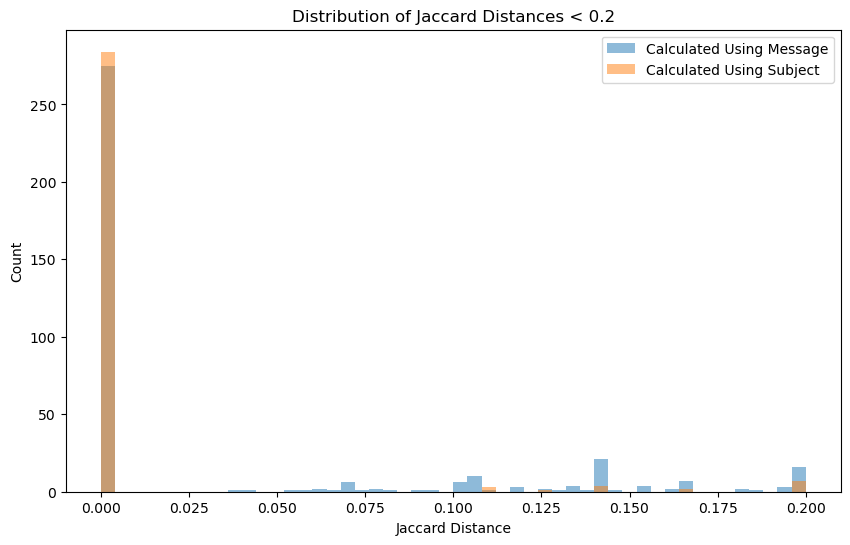

In [24]:
import matplotlib.pyplot as plt

# Extract distances as lists
text_distances1 = message_dup['distCol'].tolist()
title_distances1 = subject_dup['distCol'].tolist()

# Plot histogram
plt.figure(figsize=(10, 6))

# Plot for text distances
plt.hist(text_distances1, bins=50, alpha=0.5, label="Calculated Using Message", density=False)

# Plot for title distances
plt.hist(title_distances1, bins=50, alpha=0.5, label="Calculated Using Subject", density=False)

# Add titles and labels
plt.title("Distribution of Jaccard Distances < 0.2")
plt.xlabel("Jaccard Distance")
plt.ylabel("Count")
plt.legend()

# Display the plot
plt.show()


In [26]:
combined_dups1 = message_dup.merge(subject_dup, on=['id_A', 'id_B'], how='inner',suffixes=('_message','_subject'))

In [27]:
near_duplicates_message = message_dup.shape[0]
near_duplicates_subject = subject_dup.shape[0]
near_duplicates_both = combined_dups1.shape[0]
unique_articles_text = use_spDf.count()

NameError: name 'near_duplicates_text' is not defined

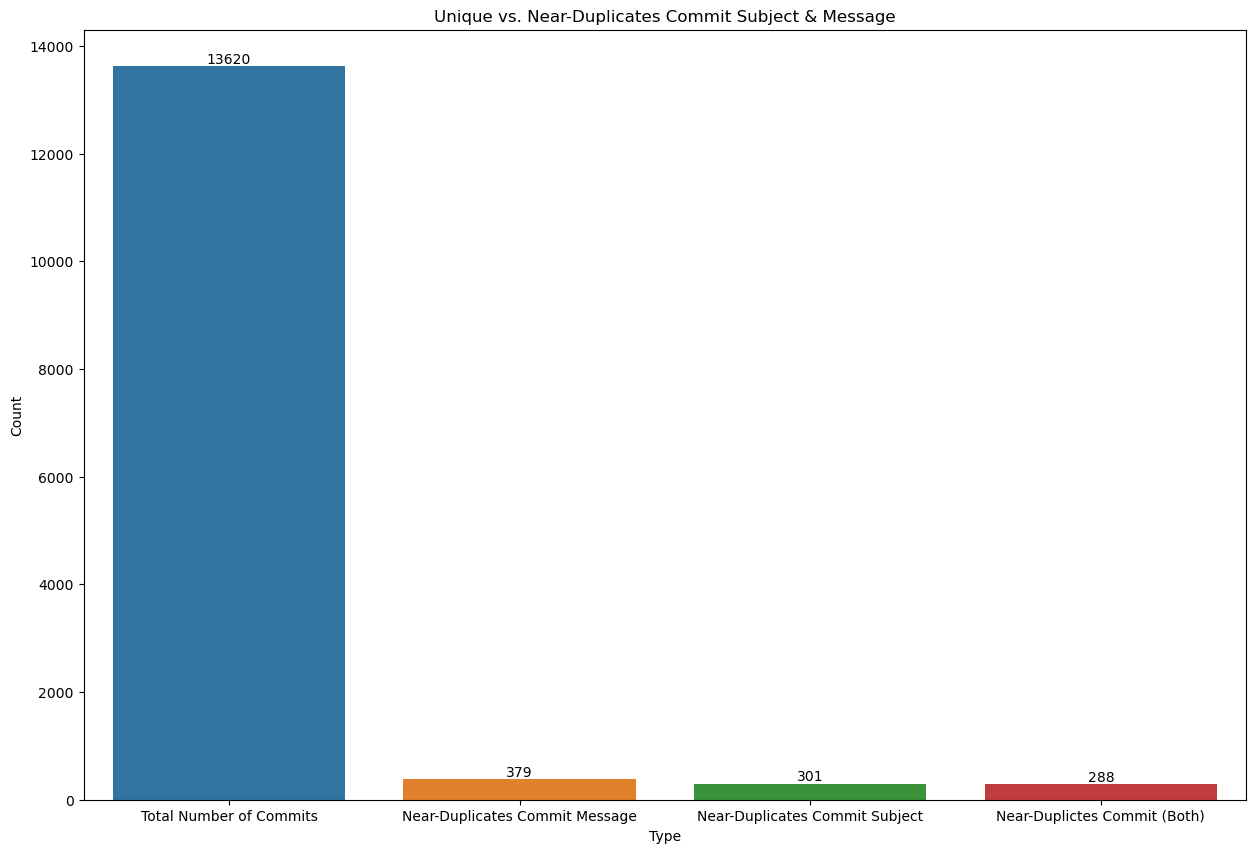

In [32]:
import seaborn as sns
data = {
    "Type": ["Total Number of Commits", "Near-Duplicates Commit Message", "Near-Duplicates Commit Subject","Near-Duplictes Commit (Both)"],
    "Count": [unique_articles_text, near_duplicates_message, near_duplicates_subject, near_duplicates_both]
}


df_bar = pd.DataFrame(data)
plt.figure(figsize=(15, 10))
sns.barplot(x="Type", y="Count", data=df_bar)

for index, row in df_bar.iterrows():
    plt.text(index,row['Count'],f"{row['Count']}",ha='center',va='bottom')
plt.title("Unique vs. Near-Duplicates Commit Subject & Message")
plt.show()